In [2]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling1D, ZeroPadding1D, Flatten, Reshape, Conv1D, BatchNormalization, Activation
from keras import regularizers
from sklearn.model_selection import train_test_split

In [3]:
q001_data_raw = np.load('/data1/ryan/train-files/train_q001_bot.npy')
q003_data_raw = np.load('/data1/ryan/train-files/train_q003_bot.npy')
q076_data_raw = np.load('/data1/ryan/train-files/train_q076_bot.npy')
q103_data_raw = np.load('/data1/ryan/train-files/train_q103_bot.npy')

#don't normalize over the whole quench, normalize each image
q001_data = np.zeros_like(q001_data_raw)
q003_data = np.zeros_like(q003_data_raw)
q076_data = np.zeros_like(q076_data_raw)
q103_data = np.zeros_like(q103_data_raw)

#it's not pretty but it works
for i, im in enumerate(q001_data_raw):
    q001_data[i,:] = q001_data_raw[i,:] / np.max(q001_data_raw[i,:])

for i, im in enumerate(q003_data_raw):
    q003_data[i,:] = q003_data_raw[i,:] / np.max(q003_data_raw[i,:])
    
for i, im in enumerate(q076_data_raw):
    q076_data[i,:] = q076_data_raw[i,:] / np.max(q076_data_raw[i,:])
    
for i, im in enumerate(q103_data_raw):
    q103_data[i,:] = q103_data_raw[i,:] / np.max(q103_data_raw[i,:])

In [4]:
qall_data = np.concatenate((q001_data, q003_data, q076_data, q103_data), axis=0)
print(qall_data.shape)

x_train_temp, x_test_temp = train_test_split(qall_data, random_state=42)
print(x_train_temp.shape)
print(x_test_temp.shape)

# x_train = np.empty((x_train_temp.shape[0], x_train_temp.shape[1], 1))
# x_test = np.empty((x_test_temp.shape[0], x_test_temp.shape[1], 1))
# x_train[:, :, 0] = x_train_temp
# x_test[:, :, 0] = x_test_temp

x_train = x_train_temp
x_test = x_test_temp

print(x_train.shape)
print(x_test.shape)

(22820, 2000)
(17115, 2000)
(5705, 2000)
(17115, 2000)
(5705, 2000)


In [5]:
input_dim = x_train.shape[1]
encoding_dim = 256

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()

# Encoder Layers
# autoencoder.add(Dense(1000, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
# autoencoder.add(Dense(1000, activation='relu'))
autoencoder.add(Dense(input_dim, activation='tanh'))

autoencoder.summary()

Compression factor: 7.8125
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2049024   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              2050000   
Total params: 5,412,048
Trainable params: 5

In [6]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_3').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2049024   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
Total params: 2,705,152
Trainable params: 2,705,152
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.optimizers import Adam
import keras.backend as K

autoencoder.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error')

print(K.eval(autoencoder.optimizer.lr))

history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=64,
                validation_data=(x_test, x_test))

1e-04
Instructions for updating:
Use tf.cast instead.
Train on 17115 samples, validate on 5705 samples
Epoch 1/20
17115/17115 [==============================] - 2s 140us/step - loss: 0.0573 - val_loss: 0.0511
Epoch 2/20
17115/17115 [==============================] - 2s 108us/step - loss: 0.0468 - val_loss: 0.0436
Epoch 3/20
17115/17115 [==============================] - 2s 108us/step - loss: 0.0412 - val_loss: 0.0399
Epoch 4/20
17115/17115 [==============================] - 2s 108us/step - loss: 0.0382 - val_loss: 0.0377
Epoch 5/20
17115/17115 [==============================] - 2s 107us/step - loss: 0.0363 - val_loss: 0.0361
Epoch 6/20
17115/17115 [==============================] - 2s 107us/step - loss: 0.0349 - val_loss: 0.0349
Epoch 7/20
17115/17115 [==============================] - 2s 107us/step - loss: 0.0338 - val_loss: 0.0340
Epoch 8/20
17115/17115 [==============================] - 2s 107us/step - loss: 0.0329 - val_loss: 0.0332
Epoch 9/20
17115/17115 [=========================

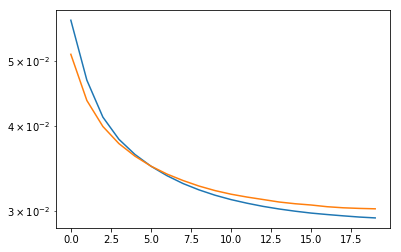

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [ ]:
autoencoder.save('case_1_autoencoder_mlp.h5')

In [ ]:
autoencoder = load_model('case_1_autoencoder_mlp.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_13').output)
encoder.summary()

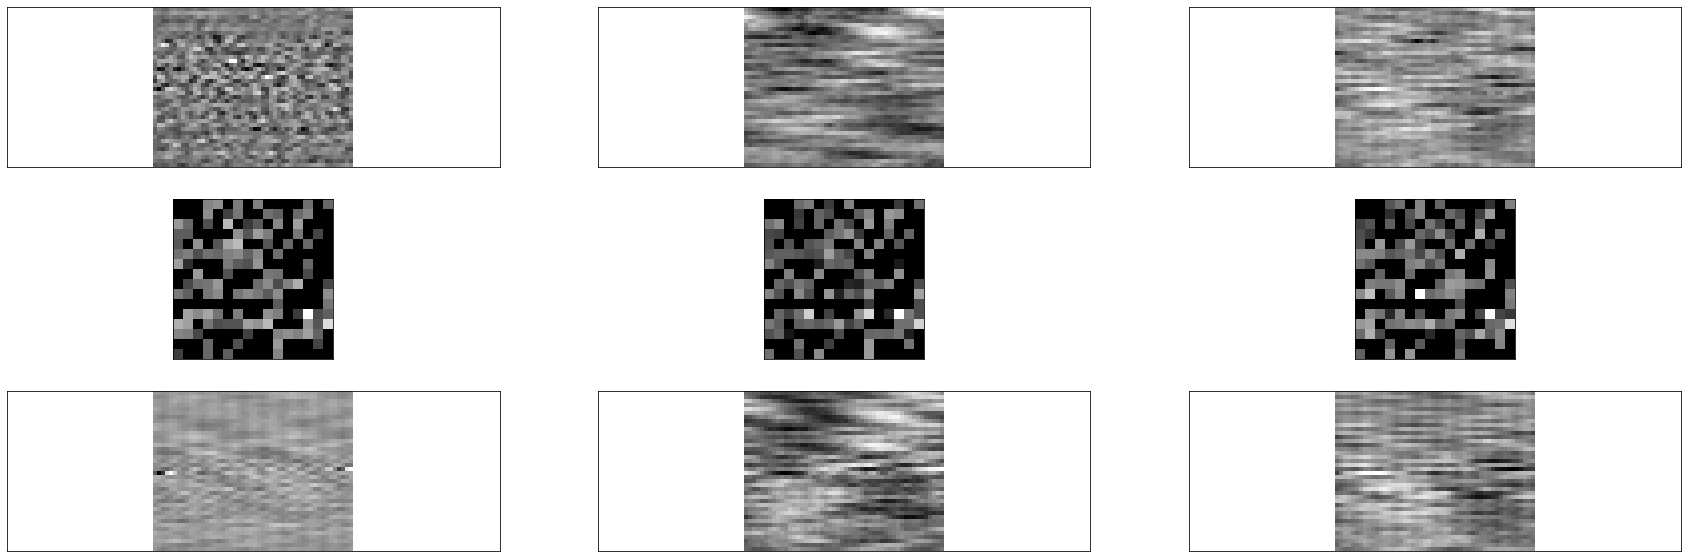

In [10]:
num_images = 3
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(30, 10))
#scalograms are 256 by 512

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(40, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 16))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(40, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
plt.show()

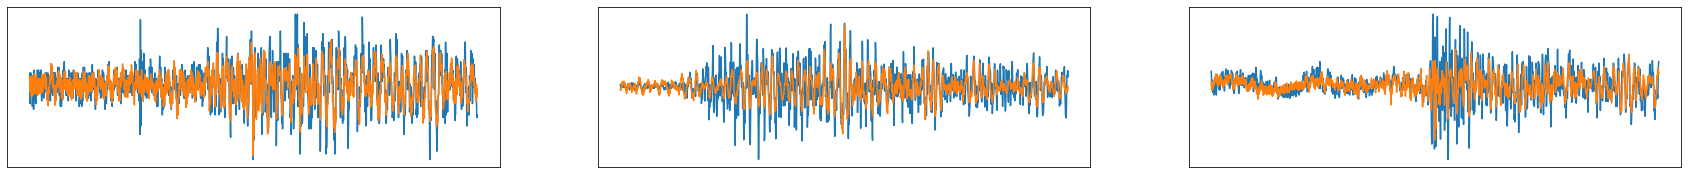

In [11]:
# The network seems to be too shallow to nicely encode any useful information

num_images = 3
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(30, 10))
#scalograms are 256 by 512

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.plot(x_test[image_idx, :])
    plt.plot(decoded_imgs[image_idx, :])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
encoded_all = encoder.predict(qall_data)

print(encoded_all.shape)

(22820, 256)


In [13]:
#Try pca on encoded images to cluster the embedded space
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
#need to flatten i guess?
img_pca = pca.fit_transform(encoded_all)

#boundary 1
boundary1 = q001_data.shape[0]
#boundary 2
boundary2 = boundary1 + q003_data.shape[0]
#boundary 3
boundary3 = boundary2 + q076_data.shape[0]

color_key=['red','orange','green','blue']
color_label=[]
for i in range(qall_data.shape[0]):
    if i <= boundary1:
        color_label.append(color_key[0])
    elif boundary1 <= i < boundary2:
        color_label.append(color_key[1])
    elif boundary2 <= i < boundary3: 
        color_label.append(color_key[2])
    else:
        color_label.append(color_key[3])
        
print(len(color_label))   
print(len(img_pca))

22820
22820


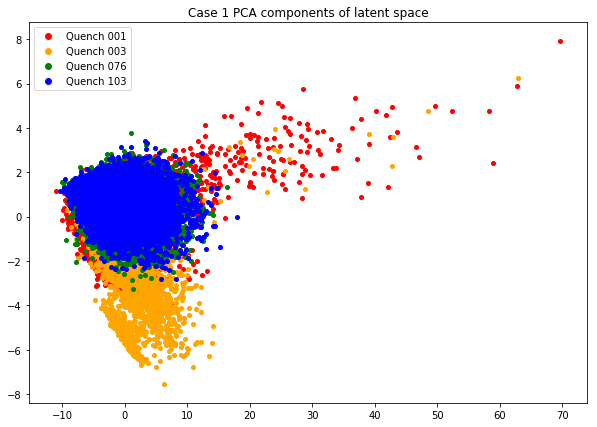

In [15]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

msize = 16

# hack the legend together
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Quench 001',
                          markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 003',
                          markerfacecolor='orange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 076',
                          markerfacecolor='green', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 103',
                          markerfacecolor='blue', markersize=8)]

# Create the figure and add our hacked legend
plt.figure(figsize=(10, 7))
for i in range(qall_data.shape[0]):
    plt.scatter(img_pca[i,0],img_pca[i,1], s=msize, color=color_label[i])
plt.title('Case 1 PCA for MLP')
plt.legend(handles=legend_elements)
plt.show()